In [4]:
# Imports e Configuração Inicial
!pip install -q tensorflow

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from typing import Tuple
from matplotlib import ticker
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

SEED = 51432
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif", size=10.5)

In [5]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Carregar dados e extrair rótulos
fold_info = pd.read_csv("/content/drive/My Drive/IA/Fiap-Alura/neto/BreaKHis_v1/Folds.csv")
fold_info["label"] = fold_info["filename"].str.extract(r"(malignant|benign)")
fold_info.head()

,fold,mag,grp,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign


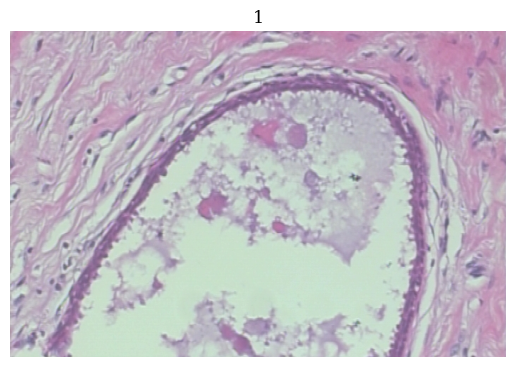

In [7]:
# Visualizar uma imagem de exemplo
path_prefix = "/content/drive/My Drive/IA/Fiap-Alura/neto/"
fold_info["filename"] = fold_info["filename"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
img_path = path_prefix + fold_info["filename"].iloc[0]

img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)

plt.imshow(img.numpy().astype(np.uint8))
plt.title(fold_info["fold"].iloc[0])
plt.axis("off")
plt.show()


In [8]:
# Filtrar imagens com magnificação ≥ 200X e fold igual a 2
img_fold_filtered = fold_info[(fold_info["fold"] == 2) & (fold_info["mag"] >= 200)]

print(f"Total de imagens selecionadas: {len(img_fold_filtered)}")
img_fold_filtered.head()


Total de imagens selecionadas: 3833


,fold,mag,grp,filename,label
7939,2,200,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
7940,2,200,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
7941,2,200,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
7942,2,200,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
7943,2,200,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign


In [9]:
# Separar conjuntos de treino e teste
train = img_fold_filtered.query("grp == 'train'")
test = img_fold_filtered.query("grp == 'test'")

train.shape, test.shape


((2682, 5), (1151, 5))

[Text(0, 0, 'benign'), Text(1, 0, 'malignant')]

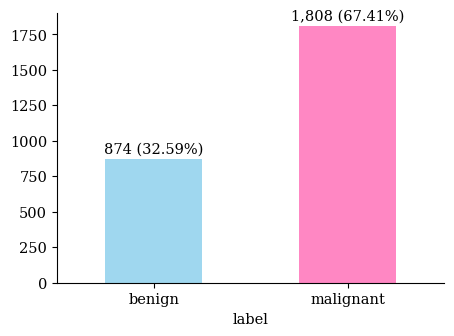

In [10]:
# Distribuição de classes no conjunto de treino
classes = {"benign": 0, "malignant": 1}
label_counts = train["label"].value_counts(ascending=True)

ax = label_counts.plot.bar(
    color=["skyblue", "hotpink"],
    alpha=0.8,
    figsize=(5, 3.5)
)
ax.bar_label(
    ax.containers[0],
    padding=2,
    labels=[f"{x:,} ({x / len(train):.2%})" for x in label_counts]
)
ax.set_xticklabels(label_counts.index, rotation=0)


In [11]:
# Avaliação de um modelo que prevê apenas casos malignos
y = train["label"].map(classes)
positive_only_preds = np.ones_like(y)

print(f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2%}")
print(f"ROC-AUC:  {metrics.roc_auc_score(y, positive_only_preds):.2%}")


Accuracy: 67.41%
ROC-AUC:  50.00%


Text(0.5, 0.98, 'ROC-AUC e Matriz de Confusão - Preditor Perfeito')

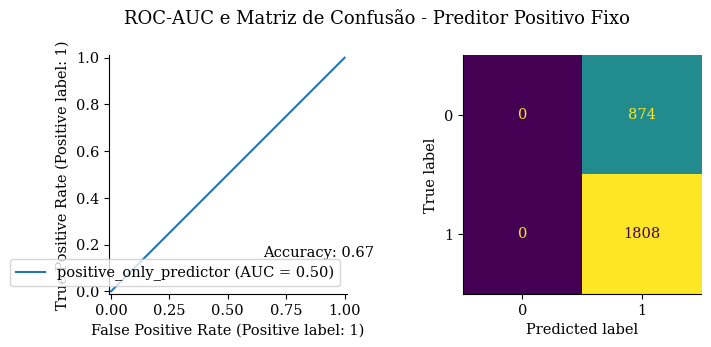

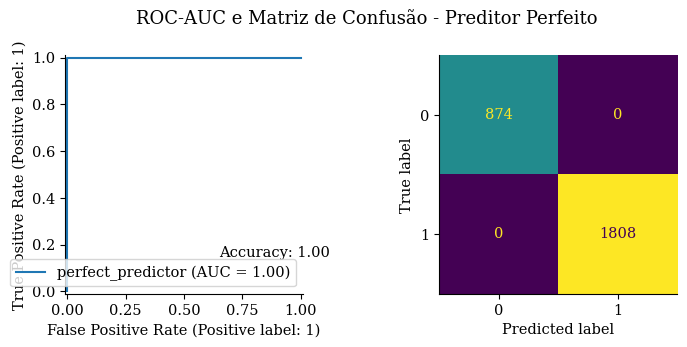

In [12]:
# Métricas para preditor positivo fixo
y = train["label"].map(classes)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y.values, positive_only_preds, ax=ax1, name="positive_only_predictor")
metrics.ConfusionMatrixDisplay.from_predictions(y.values, positive_only_preds, ax=ax2, colorbar=False)
ax1.text(0.65, 0.15, f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2f}")
fig.suptitle("ROC-AUC e Matriz de Confusão - Preditor Positivo Fixo", size=13)

# Métricas para preditor perfeito
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y.values, y.values, ax=ax1, name="perfect_predictor")
metrics.ConfusionMatrixDisplay.from_predictions(y.values, y.values, ax=ax2, colorbar=False)
ax1.text(0.65, 0.15, f"Accuracy: {metrics.accuracy_score(y, y):.2f}")
fig.suptitle("ROC-AUC e Matriz de Confusão - Preditor Perfeito", size=13)

In [13]:
# Definir caminhos das imagens e rótulos
file_paths = path_prefix + img_fold_filtered["filename"]
labels = img_fold_filtered["label"]

# Dividir em treino, validação e teste
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels, test_size=0.3, random_state=SEED, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

# Verificar tamanhos dos conjuntos
print("Treino:", X_train.shape, y_train.shape)
print("Validação:", X_val.shape, y_val.shape)
print("Teste:", X_test.shape, y_test.shape)


Treino: (2683,) (2683,)
Validação: (575,) (575,)
Teste: (575,) (575,)


In [14]:
# Tamanho padrão das imagens
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Function to preprocess image
def preprocess_image(file_path: str, label: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0  # Normalization to [0, 1]

    # Map string label to integer using TensorFlow operations
    label_str = label
    label = tf.cond(tf.equal(label_str, tf.constant('benign', dtype=tf.string)),
                    lambda: tf.constant(classes['benign'], dtype=tf.int32),
                    lambda: tf.constant(classes['malignant'], dtype=tf.int32))

    return img, label

# Create TensorFlow datasets
BATCH_SIZE = 28
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
# Arquitetura do modelo CustomCNN
custom_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),

    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    # Added another convolutional block
    layers.Conv2D(256, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5), # Adjusted dropout rate
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4), # Adjusted dropout rate
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3), # Adjusted dropout rate
    layers.Dense(1, activation="sigmoid")
], name="CustomCNN_refined") # Changed model name

custom_model.summary()

Model: "CustomCNN_refined"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_brightness               │ (None, 224, 224, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,477 (1.76 MB)

 Trainable params: 462,471 (1.76 MB)

 Non-trainable params: 6 (24.00 B)

In [16]:
# Parâmetros de imagem e lote
IMG_SIZE = 224
BATCH_SIZE = 28

# Função para carregar e pré-processar imagens
def load_image(filename: str, label: int) -> Tuple[tf.Tensor, str]:
    full_path = path_prefix + filename
    file = tf.io.read_file(full_path)
    img = tf.image.decode_png(file, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    return img, label

# Criar datasets de treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(
    train["filename"], train["label"].map(classes), random_state=SEED
)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(load_image).batch(BATCH_SIZE)
validation_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).map(load_image).batch(BATCH_SIZE)

# Criar dataset de teste
test = test.sample(frac=1, random_state=SEED)
test_ds = tf.data.Dataset.from_tensor_slices(
    (test["filename"], test["label"].map(classes))
).map(load_image).batch(BATCH_SIZE)

# Otimizar carregamento com cache e prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 75s 358ms/step - binary_accuracy: 0.6432 - loss: 0.6495 - roc_auc: 0.6678 - val_binary_accuracy: 0.7064 - val_loss: 0.5514 - val_roc_auc: 0.8761 - learning_rate: 5.0000e-04
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - binary_accuracy: 0.8576 - loss: 0.4653 - roc_auc: 0.8553 - val_binary_accuracy: 0.8599 - val_loss: 0.4818 - val_roc_auc: 0.8773 - learning_rate: 5.0000e-04
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - binary_accuracy: 0.8159 - loss: 0.4763 - roc_auc: 0.8489 - val_binary_accuracy: 0.8271 - val_loss: 0.4306 - val_roc_auc: 0.8793 - learning_rate: 5.0000e-04
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - binary_accuracy: 0.8466 - loss: 0.4604 - roc_auc: 0.8619 - val_binary_accuracy: 0.8629 - val_loss: 0.4356 - val_roc_auc: 0.8912 - learning_rate: 5.0000e-04
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - binary_accuracy: 0.8463 - loss: 0.4476 - roc_auc: 0.8637 - val_binary_accuracy: 0.8599 - val_loss: 0.4012

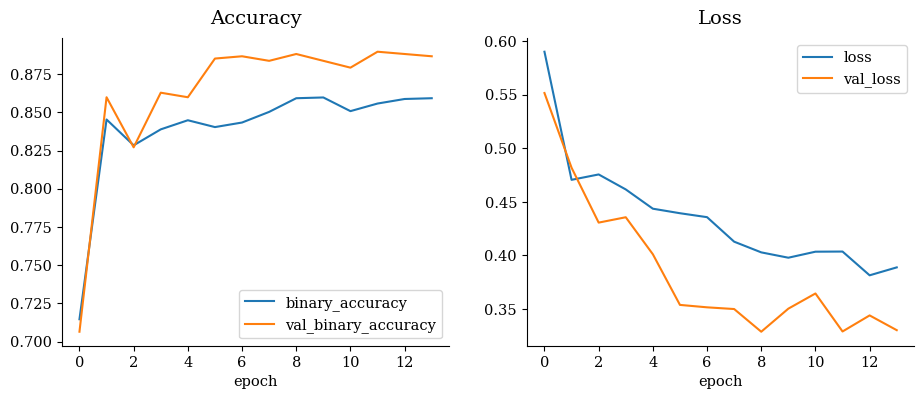

In [17]:
# Parâmetros de treinamento
MAX_EPOCHS = 25
BASE_LEARNING_RATE = 0.001

# Calculate class weights
# This assumes 'train' DataFrame and 'classes' dictionary are available
class_counts = train["label"].value_counts().to_dict()
total_count = sum(class_counts.values())
# Calculate weight for each class, giving higher weight to the minority class
class_weight = {class_name: total_count / (2.0 * count) for class_name, count in class_counts.items()}
# Map string class names to integer labels for class_weight
class_weight_int = {classes[class_name]: weight for class_name, weight in class_weight.items()}


# Função para compilar e treinar o modelo
def compile_and_fit_model(
    model: tf.keras.Model,
    learning_rate: float = BASE_LEARNING_RATE,
    epochs: int = MAX_EPOCHS,
    class_weight: dict = None # Add class_weight parameter
) -> tf.keras.callbacks.History:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name="roc_auc"), "binary_accuracy"]
    )

    early_stopping = EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, verbose=1)

    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weight # Pass class_weight to model.fit
    )

    # Visualizar métricas de treinamento
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(ncols=2, figsize=(11, 4))
    for ax, metric in zip(axes.flat, ["Accuracy", "Loss"]):
        performance_df.filter(like=metric.lower()).plot(ax=ax)
        ax.set_title(metric, size=14, pad=10)
        ax.set_xlabel("epoch")

    return history

# Treinar o modelo customizado com um learning rate ajustado e class weights
custom_history = compile_and_fit_model(custom_model, learning_rate=0.0005, class_weight=class_weight_int)


ROC-AUC:   0.82544
Acurácia:  0.84796
Loss:      0.50311



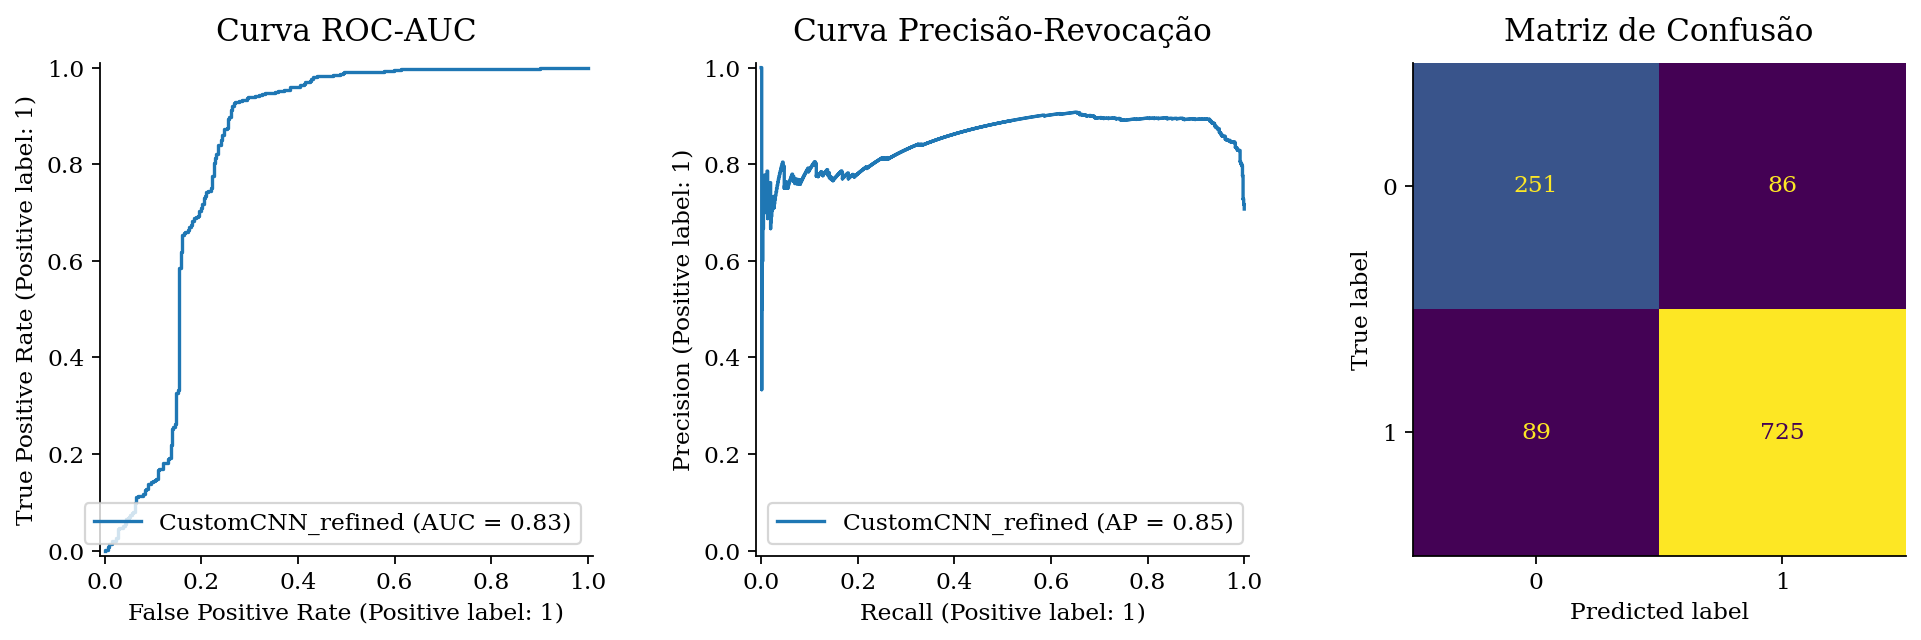

In [18]:
# Função para avaliar o modelo e visualizar métricas
def evaluate_model(model: tf.keras.Model, dataset: tf.data.Dataset = test_ds) -> None:
    loss, auc, accuracy = model.evaluate(dataset, verbose=0)
    print(f"\nROC-AUC:   {auc:.5f}")
    print(f"Acurácia:  {accuracy:.5f}")
    print(f"Loss:      {loss:.5f}\n")

    # Obter rótulos e previsões
    results = [(labels, model.predict(images, verbose=0).reshape(-1)) for images, labels in dataset.take(-1)]
    labels = np.concatenate([x[0] for x in results])
    preds = np.concatenate([x[1] for x in results])

    # Visualizar curvas e matriz de confusão
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=160)
    curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]
    for ax, curve in zip(axes[:2], curves):
        curve.from_predictions(labels, preds, ax=ax, name=model.name)

    metrics.ConfusionMatrixDisplay.from_predictions(
        labels, preds.round().astype("uint8"), ax=axes[2], colorbar=False
    )

    titles = ["Curva ROC-AUC", "Curva Precisão-Revocação", "Matriz de Confusão"]
    for ax, title in zip(axes.flat, titles):
        ax.set_title(title, size=14, pad=10)

# Executar avaliação do modelo customizado
evaluate_model(custom_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Previsões: [1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0]
Reais:     [1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0]


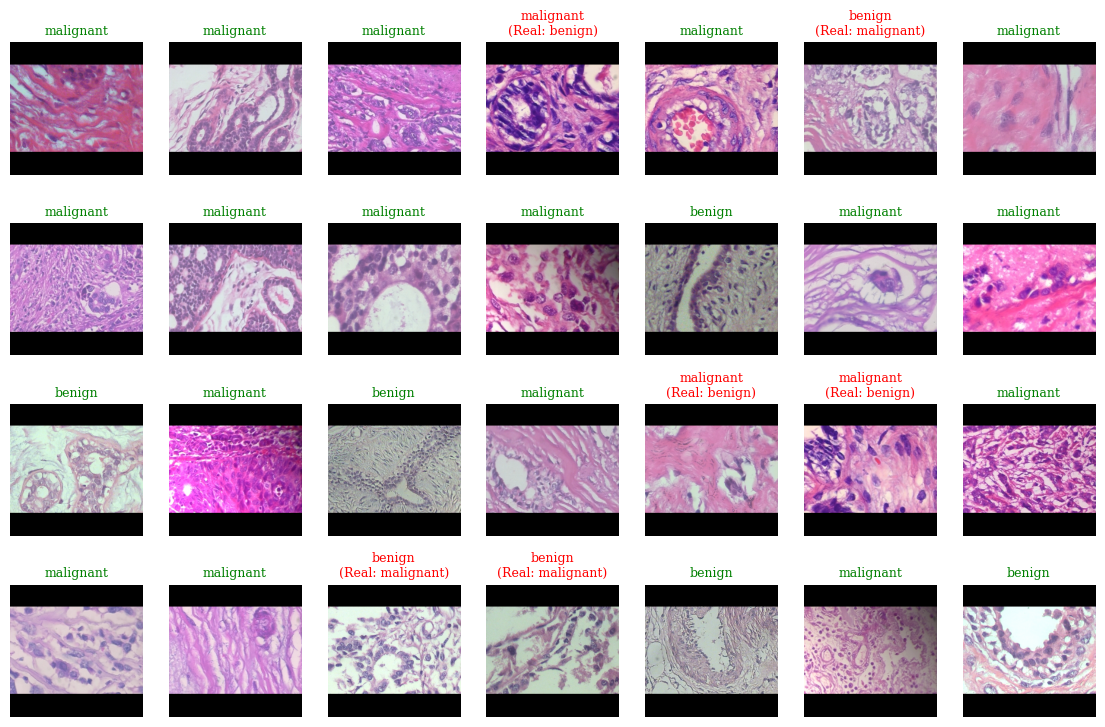

In [19]:
# Visualizar previsões do modelo em amostras do conjunto de teste
def plot_predictions(model: tf.keras.Model) -> None:
    class_names = ["benign", "malignant"] # Define class_names here
    plt.figure(figsize=(14, 9))
    for images, labels in test_ds.take(1):
        labels = labels.numpy()
        predicted_labels = model.predict(images).round().astype("uint8").reshape(-1)

        print("Previsões:", predicted_labels)
        print("Reais:    ", labels)

        for i, (pred, actual) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(4, 7, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if pred == actual:
                plt.title(class_names[labels[i]], color="green", size=9)
            else:
                plt.title(
                    f"{class_names[pred]}\n(Real: {class_names[actual]})",
                    color="red", size=9
                )
            plt.axis("off")

# Executar visualização
plot_predictions(custom_model)